In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import cvxpy as cp
from tqdm.auto import tqdm
import statsmodels.api as sm
import warnings
from scipy.linalg import sqrtm

plt.style.use('ggplot')
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
start_date = '1995-01-01'
precios_indice = yf.download("SPY", start=start_date)[["Adj Close"]] # Precios ajustados al cierre

[*********************100%%**********************]  1 of 1 completed


In [3]:
filepath = 'https://raw.githubusercontent.com/alfonso-santos/microcredencial-carteras-python-2023/main/Tema_5_APT/data/sp500_tickers.csv'
tickers_sp500 = list(pd.read_csv(filepath))

precios = yf.download(tickers_sp500, start=start_date)['Adj Close']

precios_activos_sp500 = precios.copy()
precios_activos_sp500.dropna(axis=1, inplace=True)
#ret_activos_sp500 = np.log(precios_activos_sp500).diff().dropna()

[*********************100%%**********************]  503 of 503 completed

3 Failed downloads:
['CDAY', 'BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 1995-01-01 -> 2024-04-16)')


Elegimos un universo de activos formados por num_act_max activos elegidos aleatoriamente para generar las carteras

In [4]:
num_act_max = 50

num_columnas = precios_activos_sp500.shape[1]

# Generar índices aleatorios para seleccionar num_act_max activos sin repetición

# Fijar la semilla del generador de números aleatorios
np.random.seed(42)  # Puedes usar cualquier número entero como semilla

indices_aleatorios = np.random.choice(num_columnas, size=50, replace=False)

# Seleccionar las columnas del array original usando los índices aleatorios
precios_activos_select = precios_activos_sp500.iloc[:, indices_aleatorios]



In [5]:
#ret_activos_sp500 = np.log(precios_activos_sp500).diff().dropna()

In [6]:
# Agrupar por año y mes y obtener las fechas del primer y último día de cada mes presentes en el índice

fechas_primer_dia = precios_activos_select.groupby([precios_activos_select.index.year, precios_activos_select.index.month]).apply(lambda x: x.index.min()).values
fechas_ultimo_dia = precios_activos_select.groupby([precios_activos_select.index.year, precios_activos_select.index.month]).apply(lambda x: x.index.max()).values

In [7]:
precios_activos_mes_ini = precios_activos_select.loc[fechas_primer_dia]

precios_activos_mes_fin = precios_activos_select.loc[fechas_ultimo_dia]

ret_activos_mes_ini = np.log(precios_activos_mes_ini).diff().dropna()

ret_activos_mes_fin = np.log(precios_activos_mes_fin).diff().dropna()


Calculamos las fechas de rebalanceo de la cartera, el día anterior al rebalanceo y las fechas de inicio de las ventanas usadas para calcular los pesos para rebalancear

In [8]:
rebalan_per  = 3 # Periodo de rebalanceo 3 meses
calculo_cartera_per = 60 # Periodo de datos para calcular las carteras 5 años
calculo_inicio_per = 120 # Periodo de datos para calcular la primera cartera para que empiece 31-12

if calculo_cartera_per >= calculo_inicio_per:
    raise ValueError('El periodo de cálculo de la cartera debe ser menor al periodo de inicio de cálculo')

rebalan_fechas = fechas_primer_dia[calculo_inicio_per::rebalan_per]
rebalan_fechas_final = fechas_ultimo_dia[calculo_inicio_per+rebalan_per-1::rebalan_per]

# Por si no hay fecha final para el último periodo de rebalanceo
if (len(rebalan_fechas) > len(rebalan_fechas_final)):
    rebalan_fechas = rebalan_fechas[:-1]


# Calcular la fecha que es 60 meses anterior para cada fecha en el índice
inicio_calc_fechas = pd.Series(rebalan_fechas) - pd.DateOffset(months=calculo_cartera_per)

# Asguro que , para el cáculo de la primera careta, la fecha de inicio sea la primera fecha del índice de los precios mensuales
inicio_calc_fechas[0] = precios_activos_mes_ini.index[0]

Calculo los precios de los activos los días de rebalanceo y el último día de cada periodo

In [9]:
precios_rebalan = precios_activos_select.loc[rebalan_fechas]
precios_rebalan_final = precios_activos_select.loc[rebalan_fechas_final]

Defino las funciones que calculan lospesos de las distintas carteras

In [10]:
def cartera_min_vol (ret):
    
    ''' Función que calcula la cartera de mínima varianza para un DataFrame de rendimientos
    ret: DataFrame de rendimientos
    Retorna pesos_ajustados: Array con los pesos de la cartera de mínima varianza'''
    
    if isinstance(ret, pd.DataFrame): # Verifico que el argumento sea un DataFrame
    
        num_act = ret.shape[1]
        matriz_cov = ret.cov().to_numpy()
        
            #Variables de decisión
        pesos = cp.Variable(num_act)
        
        #Restricciones
        constraints = [pesos >= 0,
                    cp.sum(pesos) == 1,
                    ]
        
        riesgo = cp.quad_form(pesos, matriz_cov) # Riesgo de la cartera
        objective = cp.Minimize(riesgo) # Minimizar la varianza

        #Problema y resuelvo
        prob = cp.Problem(objective, constraints)
        resultado = prob.solve()

        pesos_ajustados = np.array([np.round(x, 3) if x > 10**-4 else 0  for x in pesos.value]) #Pongo a cero los pesos menores a 10^-4 y redondeo a 3 decimales

        return pesos_ajustados
    
    else:
        raise ValueError('La función cartera_min_vol solo acepta un DataFrame como argumento') # Si el argumento no es un DataFrame, lanzo un error

In [11]:
def cartera_max_sharpe(ret, ret_rf):
    
    ''' Función que calcula la cartera de máximo índice de Sharpe para un DataFrame de rendimientos
    ret: DataFrame de rendimientos
    ret_rf: Rendimiento del activo libre de riesgo
    Retorna pesos_ajustados: Array con los pesos de la cartera de máximo índice de Sharpe'''
    
    if isinstance(ret, pd.DataFrame):
    
        num_act = ret.shape[1]
        matriz_cov = ret.cov().to_numpy()
        retornos_esperados = ret.mean()

        # Variable de decisión (pesos del portafolio)
        x = cp.Variable(num_act)
        # Riesgo (desviación estándar) del portafolio
        riesgo = cp.quad_form(x, matriz_cov)

        #Cálculo de pi como retornos esperados menos la rantabilidad del activo libre de riesgo
        pi = np.array(retornos_esperados - ret_rf)

        #Restricciones
        constraints = [pi @ x ==1, # para que el numerador sea 1
                    x>=0]       # sin posiciones cortas

        objective = cp.Minimize(riesgo) # Minimizo el riesgo

        # Problema de optimización
        problema = cp.Problem(objective, constraints)        

        # Resolver el problema
        resultado  = problema.solve(solver=cp.ECOS)

        # Normalizo los pesos
        pesos = x.value
        pesos /= pesos.sum()

        pesos_ajustados = np.array([np.round(x, 3) if x > 10**-4 else 0  for x in pesos])

        return pesos_ajustados
    
    else:
        raise ValueError('La función cartera_max_sharpe solo acepta un DataFrame como argumento')

In [12]:
def cartera_risk_parity (ret):
    
    ''' 
    Función que calcula la cartera de riesgo paridad para un DataFrame de rendimientos
    ret: DataFrame de rendimientos
    Retorna pesos_ajustados: Array con los pesos de la cartera de riesgo paridad'''
    
    if isinstance(ret, pd.DataFrame):
        
        num_act = ret.shape[1]
        matriz_cov = ret.cov().to_numpy()
        retornos_esperados = ret.mean().to_numpy()
        
        b = 1/num_act

        x = cp.Variable(num_act)
        gamma = cp.Variable(num_act, nonneg=True)
        psi = cp.Variable(nonneg=True)

        z = matriz_cov @ x

        obj = cp.pnorm(b**0.5 * psi - gamma, p=2)
        ret = retornos_esperados.T @ x

        constraints = [cp.sum(x) == 1,
                    x >= 0,
                    cp.SOC(psi, sqrtm(matriz_cov) @ x)]

        for i in range(num_act):
            constraints += [cp.SOC(x[i] + z[i],
                                cp.vstack([2*gamma[i], x[i] - z[i]]))
                            ]

        objective = cp.Minimize(obj * 1000)
        prob = cp.Problem(objective, constraints)
        prob.solve()

        pesos_ajustados = np.array([np.round(xi, 3) if xi > 10**-4 else 0 for xi in x.value])

        return pesos_ajustados 
    
    
    else:
        raise ValueError('La función cartera_risk_parity solo acepta un DataFrame como argumento')

In [13]:
# Calculo los pesos de la cartera de mínima volatilidad

# Uso los retornos del final del periodo de cálculo para calcular los pesos de la cartera de mínima volatilidad

min_vol_list = []
for i in range(len(rebalan_fechas)):
    pesos_tmp = cartera_min_vol(ret_activos_mes_ini.loc[inicio_calc_fechas[i]: rebalan_fechas[i]])
    min_vol_list.append(pesos_tmp)
    

pesos_ini_min_vol = pd.DataFrame(min_vol_list, columns=ret_activos_mes_fin.columns, index=rebalan_fechas)

In [14]:
# Cáculo de los pesos al final del periodo de rebalanceo

dinero_final_min_vol = (np.array(precios_rebalan_final) * pesos_ini_min_vol)

suma_dinero_final_min_vol = dinero_final_min_vol.sum(axis=1)

pesos_final_min_vol = dinero_final_min_vol.div(suma_dinero_final_min_vol, axis=0)

dif_pesos_min_vol = (pesos_final_min_vol - pesos_ini_min_vol.shift(-1)).dropna()

In [15]:
# Calculo los pesos de la cartera de max sharpe

# Uso los retornos del final del periodo de cálculo para calcular los pesos de la cartera de mínima volatilidad
ret_rf = 0.01/252 # Tasa libre de riesgo
max_sharpe_list = []
for i in range(len(rebalan_fechas)):
    pesos_tmp = cartera_max_sharpe(ret_activos_mes_fin.loc[inicio_calc_fechas[i]: rebalan_fechas[i]], ret_rf)
    max_sharpe_list.append(pesos_tmp)
    

pesos_ini_max_sharpe = pd.DataFrame(max_sharpe_list, columns=ret_activos_mes_fin.columns, index=rebalan_fechas)

In [16]:
# Cáculo de los pesos al final del periodo de rebalanceo

dinero_final_max_sharpe = (np.array(precios_rebalan_final) * pesos_ini_max_sharpe)

suma_dinero_final_max_sharpe = dinero_final_max_sharpe.sum(axis=1)

pesos_final_max_sharpe = dinero_final_max_sharpe.div(suma_dinero_final_max_sharpe, axis=0)

dif_pesos_max_sharpe = (pesos_final_max_sharpe - pesos_ini_max_sharpe.shift(-1)).dropna()

In [17]:
# Calculo los pesos de la cartera risk parity

# Uso los retornos del final del periodo de cálculo para calcular los pesos de la cartera de mínima volatilidad

risk_parity_list = []
for i in range(len(rebalan_fechas)):
    pesos_tmp = cartera_risk_parity(ret_activos_mes_fin.loc[inicio_calc_fechas[i]: rebalan_fechas[i]])
    risk_parity_list.append(pesos_tmp)

pesos_ini_risk_parity = pd.DataFrame(risk_parity_list, columns=ret_activos_mes_fin.columns, index=rebalan_fechas)

In [18]:
# Cáculo de los pesos al final del periodo de rebalanceo

dinero_final_risk_parity = (np.array(precios_rebalan_final) * pesos_ini_risk_parity)

suma_dinero_final_risk_parity = dinero_final_risk_parity.sum(axis=1)

pesos_final_risk_parity = dinero_final_risk_parity.div(suma_dinero_final_risk_parity, axis=0)

dif_pesos_risk_parity = (pesos_final_risk_parity - pesos_ini_risk_parity.shift(-1)).dropna()

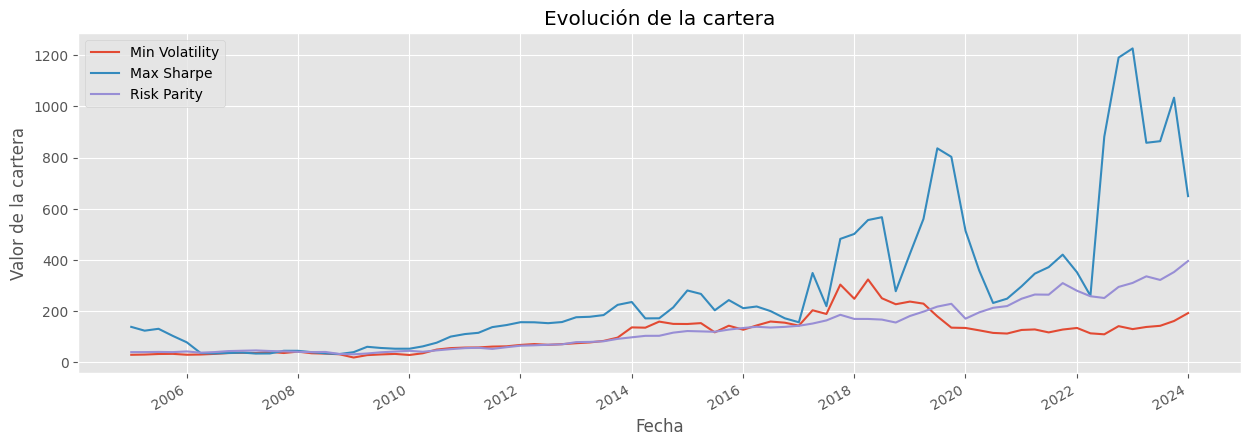

In [23]:
# Configurar el tamaño de la figura
plt.figure(figsize=(15, 5))  # Tamaño en pulgadas (ancho, alto)

# Generar las gráficas
suma_dinero_final_min_vol.plot(label='Min Volatility')
suma_dinero_final_max_sharpe.plot(label='Max Sharpe')
suma_dinero_final_risk_parity.plot(label='Risk Parity')

# Añadir título y etiquetas a los ejes
plt.title('Evolución de la cartera')
plt.xlabel('Fecha')
plt.ylabel('Valor de la cartera')

# Añadir una leyenda
plt.legend()

plt.show()

In [24]:
suma_dinero_final_min_vol[0], suma_dinero_final_max_sharpe[0], suma_dinero_final_risk_parity[0]

(28.822668313026426, 138.0184313898086, 39.27742790317535)

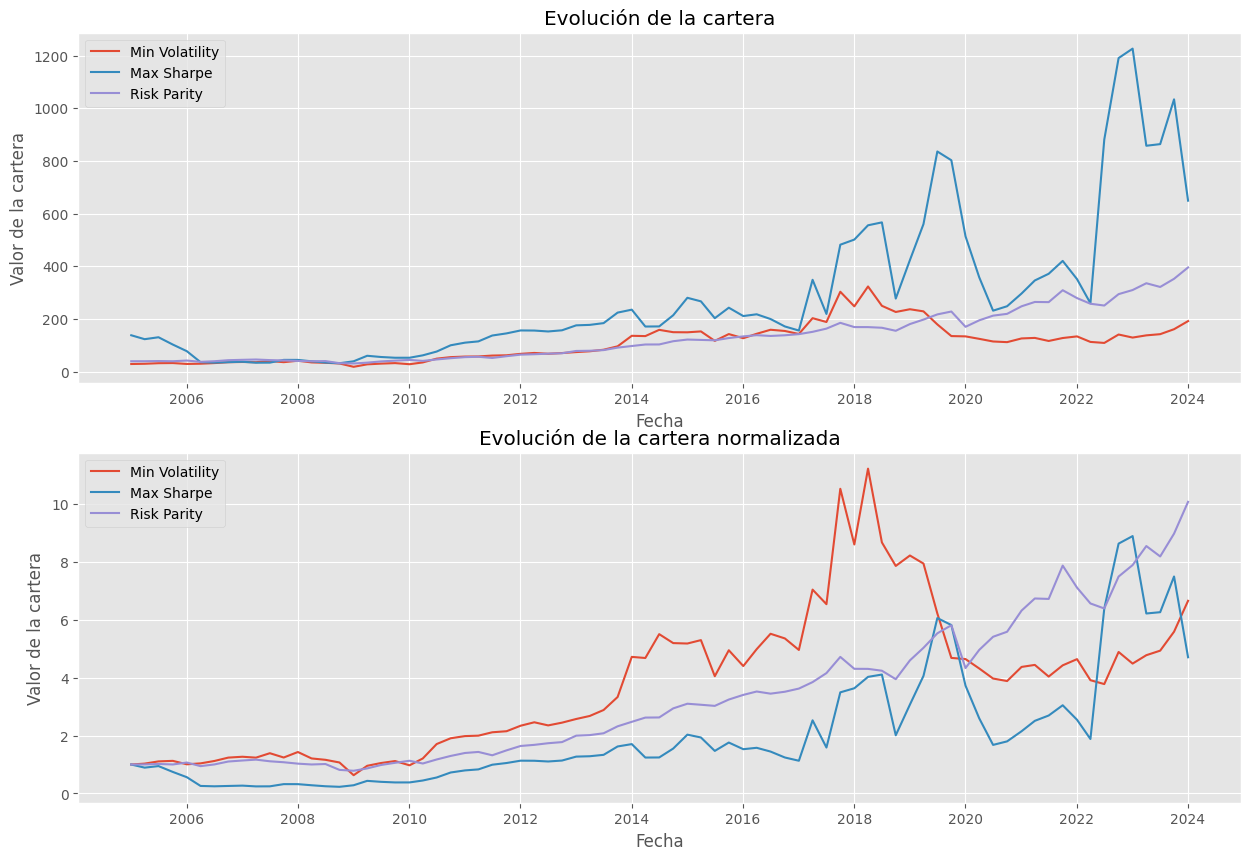

In [27]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

axes[0].plot(suma_dinero_final_min_vol, label='Min Volatility')
axes[0].plot(suma_dinero_final_max_sharpe, label='Max Sharpe')
axes[0].plot(suma_dinero_final_risk_parity, label='Risk Parity')
axes[0].set_title('Evolución de la cartera')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Valor de la cartera')
axes[0].legend()

axes[1].plot(suma_dinero_final_min_vol/suma_dinero_final_min_vol[0], label='Min Volatility')
axes[1].plot(suma_dinero_final_max_sharpe/suma_dinero_final_max_sharpe[0], label='Max Sharpe')
axes[1].plot(suma_dinero_final_risk_parity/suma_dinero_final_risk_parity[0], label='Risk Parity')
axes[1].set_title('Evolución de la cartera normalizada')
axes[1].set_xlabel('Fecha')
axes[1].set_ylabel('Valor de la cartera')
axes[1].legend()

plt.show()


<Axes: >

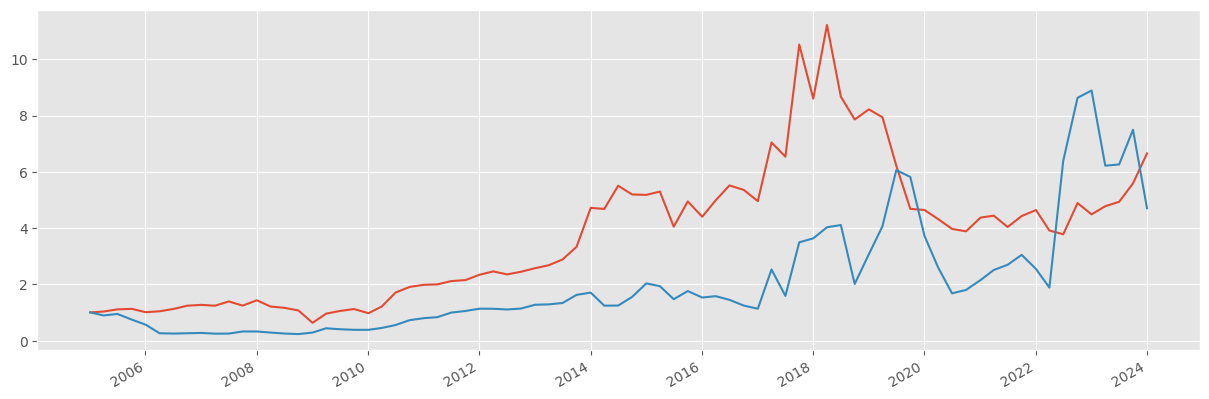

In [26]:

# Configurar el tamaño de la figura
plt.figure(figsize=(15, 5))  # Tamaño en pulgadas (ancho, alto)

# Generar las gráficas
(suma_dinero_final_min_vol/suma_dinero_final_min_vol[0]).plot(label='Min Volatility')
(suma_dinero_final_max_sharpe/suma_dinero_final_max_sharpe[0]).plot(label='Max Sharpe')

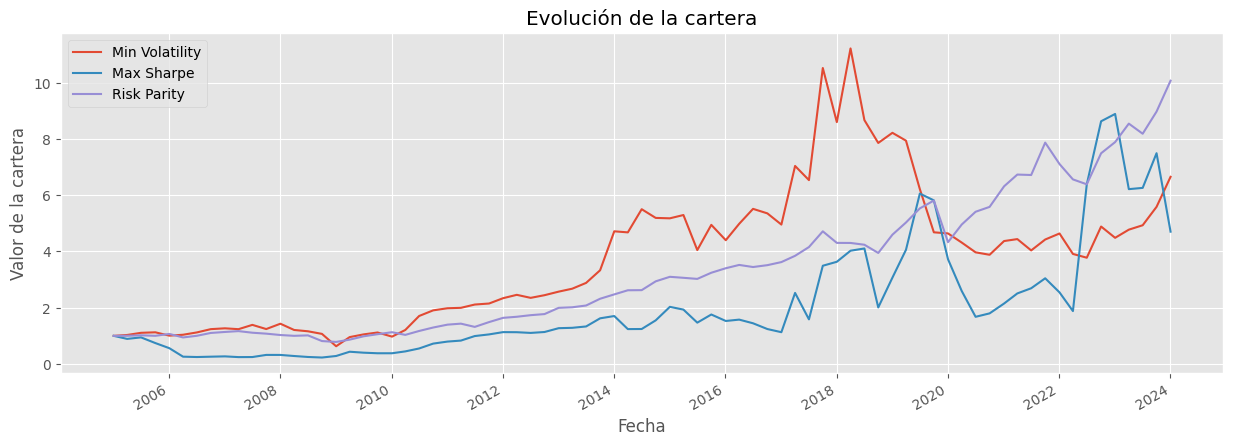

In [19]:
# Evolución de la cartera sin tener en cuenta los costes

# Configurar el tamaño de la figura
plt.figure(figsize=(15, 5))  # Tamaño en pulgadas (ancho, alto)

# Generar las gráficas
(suma_dinero_final_min_vol/suma_dinero_final_min_vol[0]).plot(label='Min Volatility')
(suma_dinero_final_max_sharpe/suma_dinero_final_max_sharpe[0]).plot(label='Max Sharpe')
(suma_dinero_final_risk_parity/suma_dinero_final_risk_parity[0]).plot(label='Risk Parity')

# Añadir título y etiquetas a los ejes
plt.title('Evolución de la cartera')
plt.xlabel('Fecha')
plt.ylabel('Valor de la cartera')

# Añadir una leyenda
plt.legend()

plt.show()

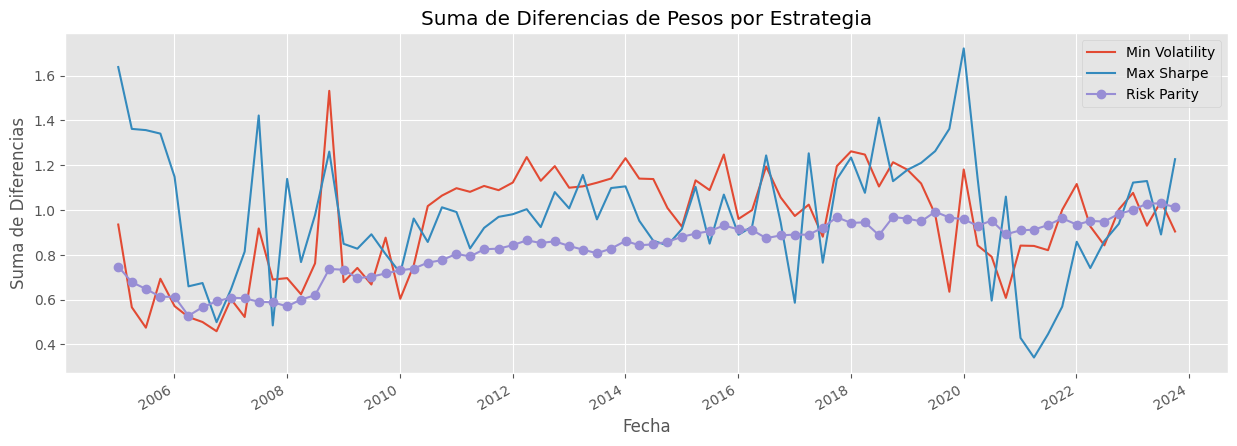

In [20]:
# Configurar el tamaño de la figura
plt.figure(figsize=(15, 5))  # Tamaño en pulgadas (ancho, alto)

# Generar las gráficas
dif_pesos_min_vol.abs().sum(axis=1).plot(label='Min Volatility')
dif_pesos_max_sharpe.abs().sum(axis=1).plot(label='Max Sharpe')
dif_pesos_risk_parity.abs().sum(axis=1).plot(label='Risk Parity', marker='o')

# Añadir título y etiquetas
plt.title('Suma de Diferencias de Pesos por Estrategia')
plt.xlabel('Fecha')  # Asumiendo que el índice es de tipo fecha
plt.ylabel('Suma de Diferencias')

# Añadir leyenda
plt.legend()

# Mostrar la gráfica
plt.show()


In [21]:
tasa_comision = 0.01

dinero_rebalan_min_vol = (dif_pesos_min_vol * dinero_final_min_vol.iloc[:-1]).abs().sum(axis=1)
dinero_rebalan_max_sharpe = (dif_pesos_max_sharpe * dinero_final_max_sharpe.iloc[:-1]).abs().sum(axis=1)
dinero_rebalan_risk_parity = (dif_pesos_risk_parity * dinero_final_risk_parity.iloc[:-1]).abs().sum(axis=1)

comisiones_min_vol = dinero_rebalan_min_vol * tasa_comision
comisiones_max_sharpe = dinero_rebalan_max_sharpe * tasa_comision
comisiones_risk_parity = dinero_rebalan_risk_parity * tasa_comision


In [22]:

# Añadimos un nuevo valor al final de la serie comisiones_min_vol con el último índice de suma_dinero_min_vol
# y asignamos el valor 0 a este nuevo índice
ultimo_indice = suma_dinero_min_vol.index[-1]
comisiones_min_vol.at[ultimo_indice] = 0

ultimo_indice = suma_dinero_max_sharpe.index[-1]
comisiones_max_sharpe.at[ultimo_indice] = 0

ultimo_indice = suma_dinero_risk_parity.index[-1]
comisiones_risk_parity.at[ultimo_indice] = 0

NameError: name 'suma_dinero_min_vol' is not defined

In [ ]:
comisiones_min_vol.tail(2)

2023-07-03    0.129035
2023-10-02    0.142465
dtype: float64

In [ ]:
suma_dinero_min_vol.tail(2)

2023-10-02    123.202153
2024-01-02    141.801218
dtype: float64

In [ ]:
ultimo_indice = suma_dinero_min_vol.index[-1]

# Añadimos un nuevo valor al final de la serie comisiones_min_vol con el último índice de suma_dinero_min_vol
# y asignamos el valor 0 a este nuevo índice
comisiones_min_vol.at[ultimo_indice] = 0

comisiones_min_vol.tail(2)

2023-10-02    0.142465
2024-01-02    0.000000
dtype: float64

In [ ]:
np.abs(pesos_ini_min_vol.diff()).sum(axis=1).sum(), np.abs(pesos_ini_max_sharpe.diff()).sum(axis=1).sum(), np.abs(pesos_ini_risk_parity.diff()).sum(axis=1).sum()

(24.973, 41.199999999999996, 4.892)

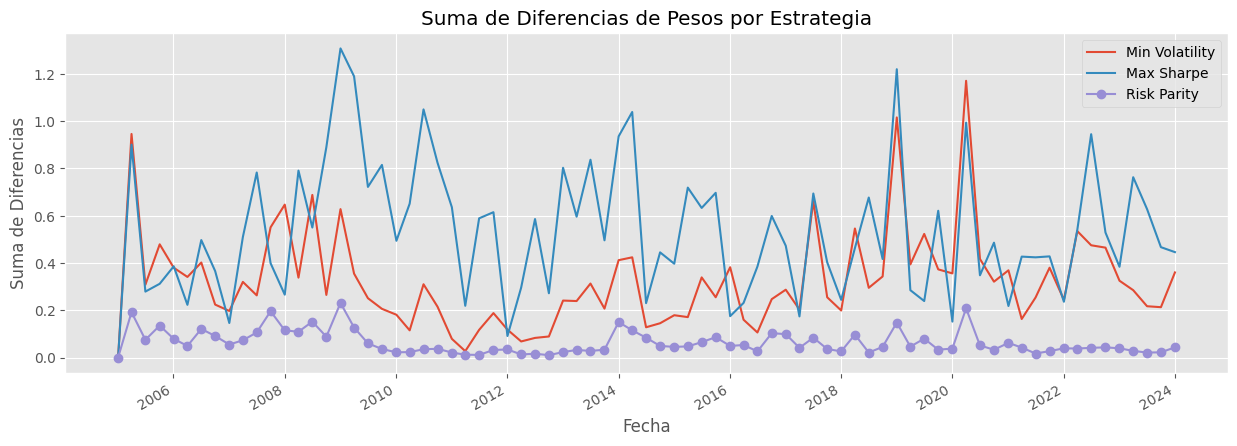

In [ ]:
# Configurar el tamaño de la figura
plt.figure(figsize=(15, 5))  # Tamaño en pulgadas (ancho, alto)

# Generar las gráficas
np.abs(pesos_ini_min_vol.diff()).sum(axis=1).plot(label='Min Volatility')
np.abs(pesos_ini_max_sharpe.diff()).sum(axis=1).plot(label='Max Sharpe')
np.abs(pesos_ini_risk_parity.diff()).sum(axis=1).plot(label='Risk Parity', marker='o')

# Añadir título y etiquetas
plt.title('Suma de Diferencias de Pesos por Estrategia')
plt.xlabel('Fecha')  # Asumiendo que el índice es de tipo fecha
plt.ylabel('Suma de Diferencias')

# Añadir leyenda
plt.legend()

# Mostrar la gráfica
plt.show()

In [ ]:
precios_activos_sp500.loc['2020':'2023']/precios_activos_sp500.loc['2020':'2023'].iloc[0]

<Figure size 640x480 with 0 Axes>

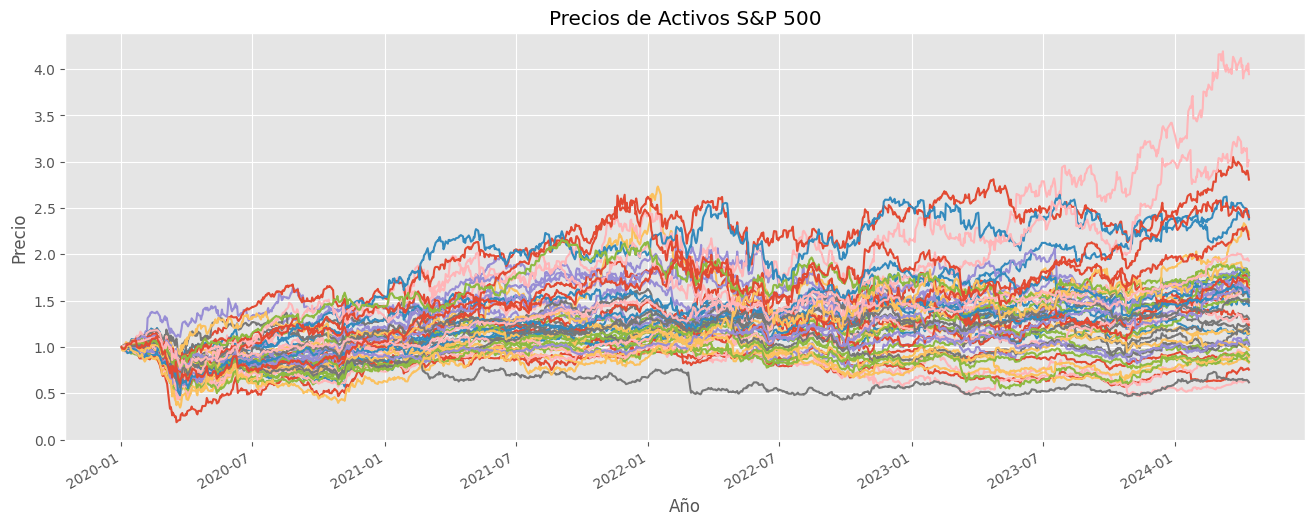

In [ ]:
# Configurar el tamaño de la figura
plt.figure()  # Tamaño en pulgadas (ancho por alto)

inicio ='2020'
fin = '2024'

# Ploteo de los datos seleccionados entre 2010 y 2013
(precios_activos_sp500.loc[inicio:fin]/precios_activos_sp500.loc[inicio:fin].iloc[0]).plot(legend=None, figsize=(16, 6))

# Añadir título y etiquetas de los ejes para claridad
plt.title('Precios de Activos S&P 500')
plt.xlabel('Año')
plt.ylabel('Precio')

# Mostrar la gráfica
plt.show()


In [ ]:
precios_rebalan.iloc[:-1,:].tail(2)

Ticker,MMM,REG,GEN,SO,CNP,AFL,HAS,PPL,TRV,BBY,...,EQR,DHI,INTU,GPC,AEP,STZ,VLO,DHR,WM,RJF
Date,,,,,,,,,,,,,,,,,,,,,
2023-07-03,79.942360,60.444717,18.116409,68.426117,28.828831,68.996696,62.199810,25.915527,170.297577,79.154305,...,64.367195,119.400749,448.702301,164.661499,82.542778,244.840424,114.690483,209.235016,169.323059,102.749527
2023-10-02,72.590294,56.842957,17.320436,61.435005,25.377552,75.596397,62.406925,22.129747,160.652405,67.411064,...,56.647003,105.714912,515.402100,143.199738,70.222733,246.808578,135.945343,213.024368,150.051163,97.353348


In [ ]:
dif_pesos_min_vol.tail(2)

Ticker,MMM,REG,GEN,SO,CNP,AFL,HAS,PPL,TRV,BBY,...,EQR,DHI,INTU,GPC,AEP,STZ,VLO,DHR,WM,RJF
2023-07-03,0.0,0.0,0.0,0.001708,0.0,0.0,0.012701,0.0,0.054131,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009978,0.0
2023-10-02,0.0,0.0,0.0,0.000000,0.0,0.0,0.025616,0.0,0.068760,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.057827,0.0


In [ ]:
dif_pesos_min_vol.shape, precios_rebalan.iloc[:-1,:].shape

((76, 50), (76, 50))

In [ ]:
dinero_rebalanceado_min_vol = (np.array(precios_rebalan.iloc[:-1,:]) * dif_pesos_min_vol)

In [ ]:
dinero_final_min_vol.iloc[:-1,:].sum(axis=1)

2005-01-03     24.566721
2005-04-01     24.917805
2005-07-01     24.556460
2005-10-03     23.357716
2006-01-03     24.275560
                 ...    
2022-10-03    126.602901
2023-01-03    116.695119
2023-04-03    123.176102
2023-07-03    111.359602
2023-10-02    132.704073
Length: 76, dtype: float64

In [ ]:
coste = 0.01
coste_balancear = dinero_rebalanceado_min_vol.sum(axis=1)*coste

In [ ]:
coste_balancear/dinero_final_min_vol

,2005-01-03 00:00:00,2005-04-01 00:00:00,2005-07-01 00:00:00,2005-10-03 00:00:00,2006-01-03 00:00:00,2006-04-03 00:00:00,2006-07-03 00:00:00,2006-10-02 00:00:00,2007-01-03 00:00:00,2007-04-02 00:00:00,...,SYK,TRV,TSCO,TXN,USB,VLO,VRTX,VTRS,VZ,WM
2005-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-10-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
